## Name of Project: Object Classification using CNN
Submitted by:-  1) Sqn Ldr Vikash Kumar (Roll No: - 194102320)
                2) Ravi Kumar Sanjay Sane (Roll No: - 194102325)

# Step 0: Import libraries

In [1]:
import glob, os
import numpy as np, matplotlib.pyplot as plt
from skimage import io, transform
from tensorflow.keras import layers, models, losses

Define other parameters and dataset paths

In [2]:
# address path of dataset
# dataset_path = './images/'
train_dataset_path = './training_set/'
test_dataset_path = './test_set/'
number_of_iterations = 5
number_of_classes = 2

# Resize all pics to 100*100
w = 100
h = 100
c = 3
class_names = ['dog' , 'cat']
plot_size = 4

# model save address path
model_path = './cnn_model/'

This function reads the dataset path and returns the dataset of pictures and labels.

In [3]:
def read_images(dataset_path):
    '''This function reads the dataset path and returns the dataset of pictures and labels'''
    complete_name = [dataset_path + x for x in os.listdir(dataset_path) if os.path.isdir(dataset_path + x)]
    images = []
    labels = []
    for temp_label, folder_name in enumerate(complete_name):
        for img in glob.glob(folder_name + '/*.jpg'):
            # print(f'Reading the image:{img}')            
            temp_img = io.imread(img, as_gray=False)
            temp_img = transform.resize(temp_img, (w, h, c))
            images.append(temp_img)
            labels.append(temp_label)
    return np.asarray(images, np.float32), np.asarray(labels, np.int32)

# Step 1: Upload Dataset

The dataset of images of cats and dogs is available at this URL https://www.kaggle.com/vaishnavkapil/feature-detection-cnn/data. Please download it.

### Create a train/test set

If only single dataset is given, we need to split the dataset with train_test_split. Else skip this step.

### Scale the features

We have to scale the features to normalize them in range of [0, 1].

In [4]:
''' In the given dataset training and testing are in separate folders '''
train_images, train_labels = read_images(train_dataset_path)
test_images, test_labels = read_images(test_dataset_path)

# No need to normalize the dataset as all dataset have same range
# train_images = train_images/255
# test_images = test_images/255

### Shuffle the dataset
We have to ensure that the input to the CNN is shuffled. Otherwise, it may possible that we will feed only one class of data, say images of only cats, in one go and the other class of data later during the program run.

In [5]:
# to shuffle the order in which data to be fed for training
num_example = train_images.shape[0]  # the total number of pictures
arr1 = np.arange(num_example)  # np.arange (start value, end value, step size)
np.random.shuffle(arr1)  # Rearrange the assignment after scrambling
train_images = train_images[arr1]
train_labels = train_labels[arr1]

# to shuffle the order in which data to be fed for testing
num_example = test_images.shape[0]  # the total number of pictures
arr2 = np.arange(num_example)  # np.arange (start value, end value, step size)
np.random.shuffle(arr2)  # Rearrange the assignment after scrambling
test_images = test_images[arr2]
test_labels = test_labels[arr2]

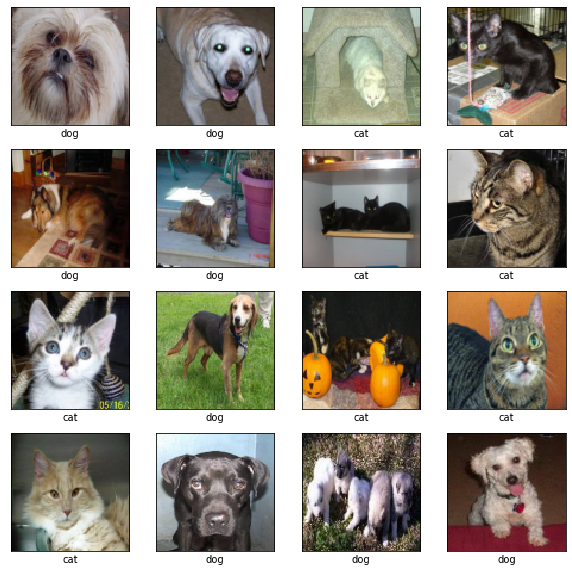

In [6]:
# Check that data is correctly read and show few input training data with labels
# Not so important step
plt.figure(figsize = (10, 10))
for i in range(plot_size**2):
    plt.subplot(plot_size, plot_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Step 2: Define the CNN architecture

As input, a CNN takes tensors of shape (image_height, image_width, color_channels). We have ignored the batch size.
In this example, we will configure our CNN to process inputs of shape (w, h, c), which is the format of cats and dogs images.

### Convolutional Layer 1: 
Applies 32 3x3 filters (extracting 3x3-pixel subregions), with ReLU activation function.

### Pooling Layer 1: 
Performs max pooling with a 2x2 filter and stride of 2(default value) (which specifies that pooled regions do not overlap).

### Convolutional Layer 2: 
Applies 64 3x3 filters, with ReLU activation function.

### Pooling Layer 2: 
Performs max pooling with a 2x2 filter and stride of 2(default value).

### Convolutional Layer 3: 
Applies 64 3x3 filters, with ReLU activation function.
    
### Flatten from 3D to 1D:
Now, we will flatten (or unroll) the 3D output to 1D, as dense layer takes 1D as input.

### Dense Layer (Logits Layer):
Now, we add two Dense layers on top. Our problem has 2 output classes, so we will use a final Dense layer with 2 outputs and a softmax activation.

In [7]:
#%% Create the convolutional base 
    
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (w, h, c)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

# cnn_model.summary()

# Add Dense layers on top

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation = 'relu'))

# Final Dense layer gives output 
cnn_model.add(layers.Dense(number_of_classes))

Here's the complete architecture of our model.

In [8]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

# Step 3: Compile and train the model

Here, "history" attribute stores a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.

In [9]:
# Compile and train (fit) the model

cnn_model.compile(optimizer = 'adam',
              loss = losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history = cnn_model.fit(train_images, train_labels, epochs = number_of_iterations, 
                    validation_data = (test_images, test_labels))

Epoch 1/5
125/125 [==============================] - 31s 250ms/step - loss: 0.6814 - accuracy: 0.5570 - val_loss: 0.7058 - val_accuracy: 0.5620
Epoch 2/5
125/125 [==============================] - 31s 249ms/step - loss: 0.6283 - accuracy: 0.6628 - val_loss: 0.6095 - val_accuracy: 0.6730
Epoch 3/5
125/125 [==============================] - 31s 248ms/step - loss: 0.5770 - accuracy: 0.6917 - val_loss: 0.5797 - val_accuracy: 0.7010
Epoch 4/5
125/125 [==============================] - 32s 254ms/step - loss: 0.5309 - accuracy: 0.7283 - val_loss: 0.6615 - val_accuracy: 0.6710
Epoch 5/5
125/125 [==============================] - 33s 267ms/step - loss: 0.4691 - accuracy: 0.7685 - val_loss: 0.5413 - val_accuracy: 0.7430


# Step 4: Evaluate the model

32/32 - 2s - loss: 0.5413 - accuracy: 0.7430

Test accuracy: 0.7429999709129333


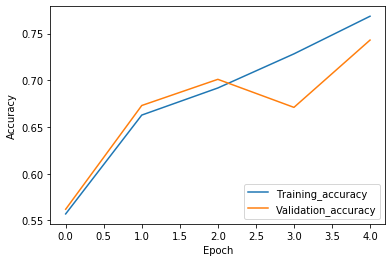

In [10]:
# Evaluate the model

plt.plot(history.history['accuracy'], label = 'Training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc = 'lower right')

test_loss, test_acc = cnn_model.evaluate(test_images,  test_labels, verbose = 2)

print('\nTest accuracy:', test_acc)

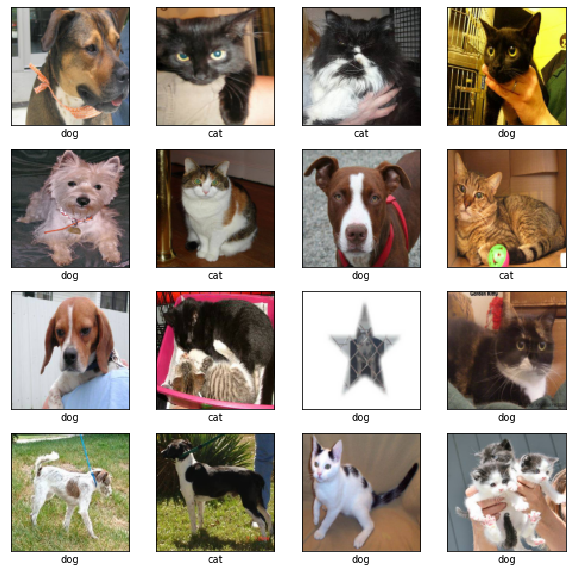

In [11]:
# Check and show the few of the output testing data and their predicted label
# Not so important step

probability_model = models.Sequential([cnn_model, layers.Softmax()])
predictions = probability_model.predict(test_images)

img = test_images[:plot_size**2]
predictions_s = probability_model.predict(img)

plt.figure(figsize = (10, 10))
for i in range(plot_size**2):
    plt.subplot(plot_size, plot_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[np.argmax(predictions_s[i])])
plt.show()

# Step 5: Save the model

In [12]:
# Save the entire model at model_path

cnn_model.save(model_path) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./cnn_model/assets


# Step 6: Load the saved model

In [13]:
# Reload a fresh Keras model from the given path

new_model = models.load_model(model_path)

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1